In [8]:
# --- Standard Library ---
import os
import re
import shutil
import requests
import getpass
import sqlite3

# --- Third-Party Libraries ---
import pandas as pd
import numpy as np
from tqdm import tqdm
from huggingface_hub import InferenceClient  # for embeddings
from langchain_core.tools import tool

# --- Local Modules ---
from database import update_dates
from tools import VectorStoreRetriever, lookup_policy
from flights import (
    fetch_user_flight_information,
    search_flights,
    update_ticket_to_new_flight,
    cancel_ticket,
)


from dotenv import load_dotenv
load_dotenv()

api_key = os.getenv('GROQ_API_KEY')
api_base = os.getenv('GROQ_API_BASE')
llm_model = os.getenv('GROQ_MODEL')
tavily_key = os.getenv("TAVILY_API_KEY")
db = os.getenv('DB_file_name')


In [9]:
# Get the FAQ text
response = requests.get(
    "https://storage.googleapis.com/benchmarks-artifacts/travel-db/swiss_faq.md"
)

# check if http requested connects
# status code of 200 (OK), nothing happens, and the script continues
# request failed (e.g. 404 Not Found, 500 Internal Server Error), 
# it raises an exception (HTTPError) and stops the program
response.raise_for_status()
# extracts the body content of the HTTP response as a string
faq_text = response.text
docs = [{"page_content": txt} for txt in re.split(r"(?=\n##)", faq_text)]

retriever = VectorStoreRetriever.from_docs(docs)

Define State

In [10]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    

Define Agent

In [15]:
from langchain_openai import ChatOpenAI  
from langchain.prompts import ChatPromptTemplate
from datetime import datetime
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            passenger_id = configuration.get("passenger_id", None)
            state = {**state, "user_info": passenger_id}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

llm = ChatOpenAI(
    model=llm_model,
    temperature=1,
    openai_api_key=api_key,
    openai_api_base=api_base,
)

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Swiss Airlines. "
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

flight_tools = [
    TavilySearchResults(max_results=1),
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    update_ticket_to_new_flight,
    cancel_ticket,
]
trip_support_agent_runnable = primary_assistant_prompt | llm.bind_tools(flight_tools)

Build Graph

In [16]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition
from utils import create_tool_node_with_fallback, handle_tool_error,_print_event

builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(trip_support_agent_runnable))
builder.add_node("tools", create_tool_node_with_fallback(flight_tools))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
trip_support_agent_graph = builder.compile(checkpointer=memory)

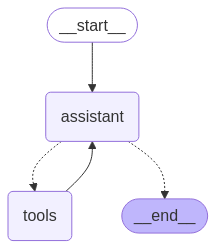

In [17]:
from IPython.display import Image, display

try:
    display(Image(trip_support_agent_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [18]:
import shutil
import uuid

# Let's create an example conversation a user might have with the assistant
tutorial_questions = [
    "Hi there, what time is my flight?",
    "Am i allowed to update my flight to something sooner? I want to leave later today.",
    "Update my flight to sometime next week then",
]

# Update with the backup file so we can restart from the original place in each section
db = update_dates(db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()
for question in tutorial_questions:
    events = trip_support_agent_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

================================ Human Message =================================

Hi there, what time is my flight?
================================== Ai Message ==================================
Tool Calls:
  fetch_user_flight_information (call_123m)
 Call ID: call_123m
  Args:
================================= Tool Message =================================
Name: fetch_user_flight_information

[{"ticket_no": "7240005432906569", "book_ref": "C46E9F", "flight_id": 19250, "flight_no": "LX0112", "departure_airport": "CDG", "arrival_airport": "BSL", "scheduled_departure": "2025-04-06 22:26:50.677227-04:00", "scheduled_arrival": "2025-04-06 23:56:50.677227-04:00", "seat_no": "18E", "fare_conditions": "Economy"}]
================================== Ai Message ==================================
Tool Calls:
  lookup_policy (call_3vp0)
 Call ID: call_3vp0
  Args:
    query: departure time flexibility policy 3442 587242
================================= Tool Message =============================

BadRequestError: Error code: 400 - {'error': {'message': "'messages.19' : for 'role:tool' the following must be satisfied[('messages.19.content' : value must be a string)]", 'type': 'invalid_request_error'}}